In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchsummary import summary

Files already downloaded and verified
Files already downloaded and verified


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


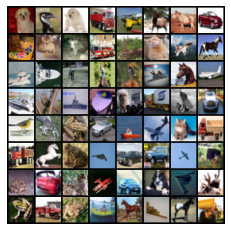

In [12]:
BATCH_SIZE = 64
transform = transforms.Compose([transforms.ToTensor()])## transformations 

## download and load training, testing dataset
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

dataiter = iter(cifar_trainloader) ## get some random training images
images, labels = dataiter.next()

images_grid = torchvision.utils.make_grid(images) ## show images
plt.imshow(np.transpose(images_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True) # load the existing model (Resnet18) pretrained model: use weights from ImageNet dataset(선 학습된 weight 가져온다.)
model_ft = model_ft.to(device)
# print(model_ft)
summary(model_ft, input_size=(3,32,32))  # 진행될수록 channel은 늘고, pooling하기 때문에 가로세로는 줄어든다. 마지막에 1000이 되는 이유는, imagenet class가 1000개여서

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [16]:
print(model_ft.fc)

fc_num_in_fts = model_ft.fc.in_features
fc_num_out_fts = model_ft.fc.out_features

print('LAST - fc: ', fc_num_in_fts, fc_num_out_fts) # 마지막 출력값인 (fc) 형태를 변경해아한다.

Linear(in_features=512, out_features=1000, bias=True)
LAST - fc:  512 1000


In [17]:
model_ft.fc = nn.Linear(fc_num_in_fts, 10) # .Linear : fully-connected layer / in 512, out 10으로 수정된 새로운 layer를 넣어준다.

model_ft = model_ft.to(device)
summary(model_ft, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [19]:
## compute stat
def compute_stat(outputs, labels, stats):
    _, preds = torch.max(outputs, 1) # 가장 큰 값을 찾아냄
    stats['n_corr'] += torch.sum(preds == labels).item() # dict의 key와 value 쌍을 얻을 수 있다.
    stats['n'] += torch.numel(labels) # input tensor의 총 요소 수를 반환합니다

    return stats

def train_model(model, criterion, optimizer, trainloader, device, num_epochs=25):
  epoch_stat = {'n_corr': 0, 'n': 0}

  for epoch in range(num_epochs):
      train_running_loss = 0.0
      train_acc = 0.0

      model.train()  # Set model to training mode

      ## training step / batch 하나씩 처리하는 for문
      for i, (images, labels) in enumerate(trainloader):
          
          images = images.to(device) # cpu에서 gpu로 data 넘김
          labels = labels.to(device)

          ## forward + backprop + loss
          optimizer.zero_grad() # grdient 계산된 것이 optimizer에 더해지는 방식으로 계산되는데, 새로운 배치에서는 초기 상태로 만들어줘야 한다.
          outputs = model(images) # feed forward
          loss = criterion(outputs, labels) # 오차 = 어떻게 계산할껀지 정한거(예측치, 실제 정답)
          loss.backward() # loss에 따라 gradient가 계산됨

          ## update model params
          optimizer.step() # weight 값들이 조절됨

          train_running_loss += loss.detach().item() # detach() 메서드는 그래디언트가 필요하지 않다고 선언된 텐서에 새 뷰를 생성. 에러값이 어떻게 계산되었는지 확인하기위해 더하주고 있음
          epoch_stat = compute_stat(outputs, labels, epoch_stat) # 얼마나 정답인지 등 stat 표기.
      
      model.eval() # evaluation(평가) mode로 전환
      print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
            %(epoch, train_running_loss / i, epoch_stat['n_corr'] / epoch_stat['n'] * 100)) 
      
  return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 마지막 layer는 우리가 class를 1000개에서 10개로 줄였기 때문에 weight 값이 임의로 설정되어있다. = 학습을 다시 해야함.(앞에서 사용한 model을 이용해보자)
criterion_ft = nn.CrossEntropyLoss() # loss function
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)
model_ft = train_model(model_ft, criterion_ft, optimizer_ft, cifar_trainloader, device, num_epochs=5)

In [ ]:
test_stat = {'n_corr': 0, 'n': 0}
for i, (images, labels) in enumerate(cifar_testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_ft(images)
    test_stat = compute_stat(outputs, labels, test_stat)
        
print('Test Accuracy: %.2f'%( test_stat['n_corr'] / test_stat['n'] * 100))